In [1]:
using Revise

In [2]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra
;

[ Info: Precompiling QuantumStates [17f0441f-15e0-42ae-a101-302633ff8f0f]
[ Info: Precompiling OpticalBlochEquations [691d0331-80d3-41b1-b293-7891a6f4a14f]


In [3]:
const λ = 1
const Γ = 2π
const m = 1
const k = 2π / λ
;

In [5]:
H_operator = :(
    T * L +
    B_z * Zeeman_L0
)
parameters = @params begin
    T = 1e3
    B_z = 0.0
end

# Create basis states
QN_bounds = (L = 0, N = 1)
ground_states = enumerate_states(AngularMomentumState_Labelled, QN_bounds)
QN_bounds = (L = 1, N = 0)
excited_states = enumerate_states(AngularMomentumState_Labelled, QN_bounds)

# Create Hamiltonian
basis = [ground_states; excited_states]
H = Hamiltonian(basis=basis, operator=H_operator, parameters=parameters)

# 
# TDM_x1(state, state′) = sum(arg * TDM(state, state′, q-2) + conj(arg * TDM(state′, state, q-2)) for (q,arg) ∈ enumerate(rotate_pol(σ⁺, +x̂)))
# TDM_x2(state, state′) = sum(arg * TDM(state, state′, q-2) + conj(arg * TDM(state′, state, q-2)) for (q,arg) ∈ enumerate(rotate_pol(σ⁺, -x̂)))
# H = add_to_H(H, :s, TDM_x1 + TDM_x2)
# H.parameters.s = 1.0

evaluate!(H)
QuantumStates.solve!(H)

update_basis_tdms!(H)
update_tdms!(H)
d = H.tdms

# d[1:3,1:3,:] .= 0.0
# d[4:6,4:6,:] .= 0.0
;

In [6]:
# heatmap(abs.(real.(d[:,:,3].^2)), c=cgrad(:hot, rev=true), legend=:none)
# plot!(
#     size=(500,500),
#     box=:on,
#     grid=true                                                                                                                                       
#     )
# yflip!(true)

In [7]:
H.states[1] |> display
H.states[2] |> display
H.states[3] |> display

State{AngularMomentumState_Labelled}(0.0, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 0, 0, (M = 0:0,))], ComplexF64[1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 1)

State{AngularMomentumState_Labelled}(0.0, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 0, 0, (M = 0:0,))], ComplexF64[0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 2)

State{AngularMomentumState_Labelled}(0.0, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 0, 0, (M = 0:0,))], ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im], 3)

In [9]:
H.states[4] |> display

State{AngularMomentumState_Labelled}(1000.0, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 0, 0, (M = 0:0,))], ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im], 4)

In [60]:
# Laser parameters
Δ = +2Γ
s = 1.0

# Frequency of the lasers (in angular frequency units)
ω1 = 2π * (energy(H.states[end]) - energy(H.states[1])) + Δ
ω2 = 2π * (energy(H.states[end]) - energy(H.states[4])) - Δ

ϵ_(ϵ1) = t -> ϵ1

k̂ = +x̂; ϵ1 = ϵ_( -im .* rotate_pol(σ⁺, k̂)); laser1 = Field(k̂, ϵ1, ω1, s)
k̂ = -x̂; ϵ2 = ϵ_( -im .* rotate_pol(σ⁺, k̂)); laser2 = Field(k̂, ϵ2, ω1, s)
k̂ = +ŷ; ϵ3 = ϵ_( -rotate_pol(σ⁺, k̂)); laser3 = Field(k̂, ϵ3, ω1, s)
k̂ = -ŷ; ϵ4 = ϵ_( -rotate_pol(σ⁺, k̂)); laser4 = Field(k̂, ϵ4, ω1, s)
k̂ = +ẑ; ϵ5 = ϵ_( rotate_pol(σ⁺, k̂)); laser5 = Field(k̂, ϵ5, ω1, s)
k̂ = -ẑ; ϵ6 = ϵ_( rotate_pol(σ⁺, k̂)); laser6 = Field(k̂, ϵ6, ω1, s)

lasers = [laser1, laser2, laser3, laser4, laser5, laser6]
;

In [61]:
particle = Particle()
ρ0 = zeros(ComplexF64, length(H.states), length(H.states))
ρ0[1,1] = 1.0
freq_res = 1e-1

p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res, nothing)

t_end = 20p.period
tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p)
;

In [62]:
callback = PeriodicCallback(reset_force!, prob.p.period)

prob.p.r0 = (0., 0., 0.3) .* 2π
prob.p.v = (0., 0., 0.)
@time sol = DifferentialEquations.solve(prob, alg=DP5(), reltol=1e-3, callback=callback)
prob.p.force_last_period .* 1e3

  5.457286 seconds (4.24 M allocations: 274.969 MiB, 3.69% gc time, 99.75% compilation time)


3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
  7.277667389278574e-19
 -9.73684544973013e-18
  0.020521609482116652

In [63]:
prob.p.populations

4-element Vector{ComplexF64}:
    0.3728707964560895 + 0.0im
   0.24979582043457194 + 0.0im
    0.3773297056140485 + 0.0im
 3.6774952922622514e-6 + 0.0im

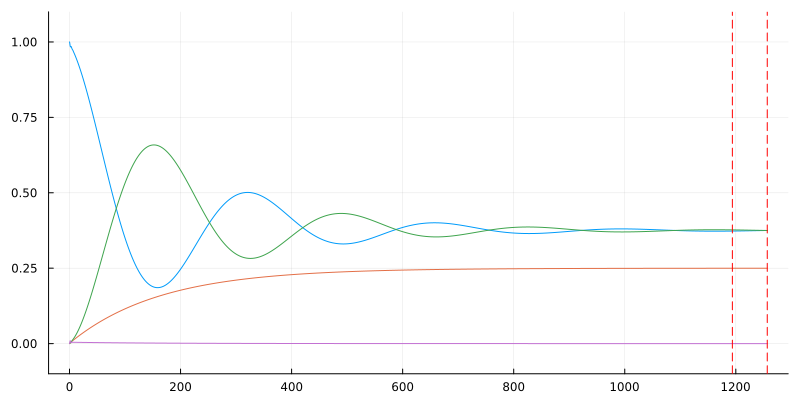

In [64]:
using Plots
plot_us = sol.u#[1:10:end]
plot_ts = sol.t#[1:10:end]

n_states = size(p.ρ_soa, 1)
plot(size=(800, 400), ylim=(-0.1, 1.1), legend=nothing)
for i in 1:n_states
    state_idx = n_states*(i-1) + i
    plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
end
plot!()
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

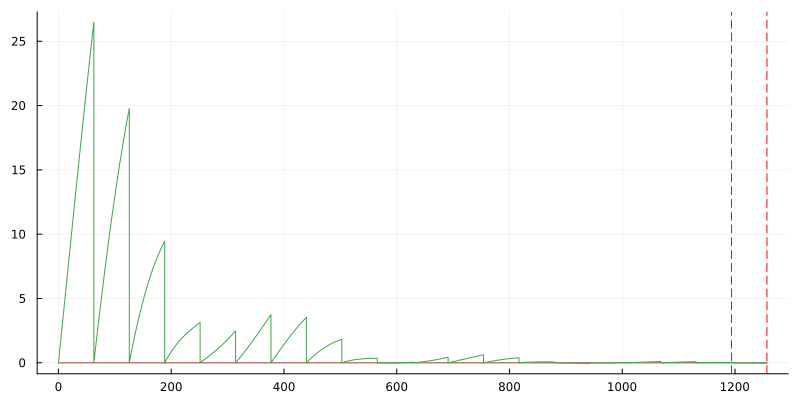

In [65]:
plot(size=(800, 400), legend=nothing)
plot!(plot_ts, 1e3 .* [real(u[end-2]) for u in plot_us] ./ prob.p.period)
plot!(plot_ts, 1e3 .* [real(u[end-1]) for u in plot_us] ./ prob.p.period)
plot!(plot_ts, 1e3 .* [real(u[end]) for u in plot_us] ./ prob.p.period)
plot!()
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

In [66]:
using Distributions
uniform_dist = Uniform(0, 2π)
function sample_direction(r=1.0)
    θ = 2π * rand()
    z = rand() * 2 - 1
    return (r * sqrt(1 - z^2) * cos(θ), r * sqrt(1 - z^2) * sin(θ), r * z)
end
;

## Force versus magnetic field

In [67]:
function prob_func!(prob, scan_params, i)
    p = prob.p
    
    # Update velocity and position
    p.particle.v .= scan_params[i].v
    p.particle.r0 .= scan_params[i].r
    
    # Update magnetic field
    H = p.extra_p.H
    H.parameters.B_z = scan_params[i].B
    evaluate!(H)
    QuantumStates.solve!(H)
    
    # Update transition dipole moments
    update_basis_tdms!(H)
    update_tdms!(H)
    new_d = H.tdms
    
    new_p = obe(p.ρ0, p.particle, H.states, p.extra_p.lasers, new_d, nothing, true, true, p.λ, p.Γ, p.freq_res, p.extra_p)
    
    return remake(prob, p=new_p)
end
function output_func(p, sol)
    f = p.force_last_period
    return f
end
;

In [74]:
using RectiGrids

freq_res = 1e-2
extra_p = (H=H, lasers=lasers)
p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

t_end = 10p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-3, save_on=false)

Bs = (0:0.25:10.0)
di = 7
rs = vcat([(n1*λ/(di+1), n2*λ/(di+1), n3*λ/(di+1)) .* 2π for n1 ∈ 0:di, n2 ∈ 0:di, n3 ∈ 0:di]...)
vs = [sample_direction(0.0) for _ in 1:1]

scan_values = (B = Bs, r = rs, v = vs)
scan_values_grid = RectiGrids.grid(scan_values)
;

In [75]:
@time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:03:05


185.417847 seconds (7.73 M allocations: 1.078 GiB, 0.11% gc time)


In [76]:
averaged_forces = []
@time for (i,B) ∈ enumerate(Bs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.B == B]
    push!(averaged_forces, mean([f[3] for f in forces[idxs]]))
end

  0.139016 seconds (78.60 k allocations: 6.079 MiB, 96.00% compilation time)


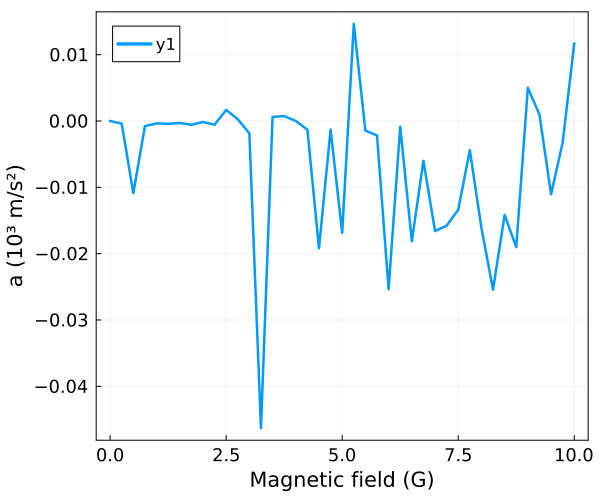

In [77]:
plot(Bs, 1e3 .* averaged_forces,
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    # ylim=(-3,23),
    size=(600,500)
    )

In [78]:
averaged_populations = []
@time for (i,B) ∈ enumerate(Bs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.B == B]
    push!(averaged_populations, mean([p for p in populations[idxs,:]], dims=1))
end

  0.115097 seconds (53.41 k allocations: 5.044 MiB, 95.95% compilation time)


In [79]:
averaged_populations[4]'

4×1 adjoint(::Matrix{Float64}) with eltype Float64:
 0.1791257222309564
 0.4716420202678737
 0.33878624770171667
 0.010446009799451872